In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce # for merging dataframes
import re
import os

In [11]:
def extract_measurement(b_list, b_index):

    # this function extract the data points from B3,B4,B5 and 
    # And return clean data to get_measurment() in dictionay format 
    
    x_spos = b_list.index('LengthValue') # starting index of the x values
    y_spos = b_list.index('Value')# starting index of the y values
    y_epos = len(b_list)# the ending pos of y values
    
    x = b_list[x_spos + 1:y_spos]
    y = b_list[y_spos + 1: y_epos-1]

    null_index = set() # a set to keep the index of null values in either x or y
    
    # loop over x and get the index of the 'null' elements
    for index,value in enumerate(x):
        if value == "null":
            null_index.add(index)

    # loop over y and get the index of the 'null' elements
    for index,value in enumerate(y):
        if value == "null":
            null_index.add(index)    
    

    # removing the x,y pair with null value in either of them
    x = [value for idx, value in enumerate(x) if idx not in null_index]
    y = [value for idx, value in enumerate(y) if idx not in null_index]

    # changing the elements of x and y from string to float
    x_float =[float(item) for item in x]
    y_float =[float(item) for item in y]

    xy_dict = dict(zip(x_float,y_float)) # zip x and y  in dictionary
    xy_dict = {key: xy_dict[key] for key in xy_dict if key <= 500} # delete x,y pair for x > 500
    #print(len(xy_dict))

    decode_dic = {0:'B3',1:'B4',2:'B5'}
    b_width = 'width_'+ decode_dic[b_index]
    
    b_df = pd.DataFrame(list(xy_dict.items()),columns = ['length',b_width])
    b_df['length'] = b_df['length'].astype(int) # convert float value  to int
    
    b_df = b_df.groupby('length',as_index=False)[b_width].mean()
    
    return b_df




def get_measurement(coil_id):

    # this function load the data for B3,B4,B5 measurments
    # It split the data based on ";"
    # It calls extract_measuremnt() function to extract the 
    # clean data pairs for B3,B4,B5
    # And return the values in dictionary format

    print('************************************')
    print("coil Id: ", coil_id)
    root_directory = "data/SampleProcessedData/"

    b3_df = pd.read_csv(root_directory + str(coil_id ) + "B3.csv")
    b4_df = pd.read_csv(root_directory + str(coil_id ) + "B4.csv")
    b5_df = pd.read_csv(root_directory + str(coil_id ) + "B5.csv")

    b3_list = re.split(';', str(b3_df.columns))
    b4_list = re.split(';', str(b4_df.columns))
    b5_list = re.split(';', str(b5_df.columns))

    b_lists = [b3_list,b4_list,b5_list]

    all_B_df = [] # this list contain all b_df for B3,B4,B5(it is list of dataframes )
    
    for b_index, b_list in enumerate(b_lists):
        all_B_df.append(extract_measurement(b_list, b_index))

    
    # merge the dataframes for B3,B4,B5
    dfs = [all_B_df[0], all_B_df[1], all_B_df[2]] #define list of DataFrames
    final_B_df = reduce(lambda  left,right: pd.merge(left,right,on=['length'],
                                            how='outer'), dfs)# merge all DataFrames into one
    
    
    print('*********************************')
    
    return final_B_df # return list of dataframes
    
    

In [12]:
def label_observation():

    # this function get the coil_Id and call the get_measurment()
    # function to get the cleaned value for B3,B4 and B5 in dictionary format
    # from the dictionary it checks if there is constriction or not
    # and add the result to the coil_df

     #load the dataset
     coil_df = pd.read_excel('data/CoilDataInput.xlsx')
     count = 0

   #   for name, value in coil_df['coil'].items():
   #      #print(value)
        
   #      pass

     measurement_df = get_measurement(311224)
     #print(measurement_df.head())
     targeted_measurement_df = measurement_df[(measurement_df.length >=120) &(measurement_df.length <= 190)]
     #print(targeted_measurement_df)
     targeted_measurement_df['width_difference'] = targeted_measurement_df['width_B5'] - targeted_measurement_df['width_B4'] 
	
     def constriction_status(value):
        if abs(value) <= 5:
          return 0
        else:
          return 1
      
     targeted_measurement_df['Is_constriction'] = targeted_measurement_df['width_difference'].map(constriction_status)
     print(targeted_measurement_df)
     print(targeted_measurement_df['Is_constriction'].value_counts())
     if 1 in targeted_measurement_df['Is_constriction']:
       constriction = 1
     else:
       constriction = 0
     print('Is_constriction', constriction)

     # 311210 empty b5

     # 311248 good
     
     return measurement_df

    

************************************
coil Id:  311224
*********************************
     length     width_B3     width_B4  width_B5  width_difference  \
120     120  1441.200000  1442.250000   1440.50         -1.750000   
121     121  1441.250000  1441.666667   1438.65         -3.016667   
122     122  1440.700000  1441.400000   1438.45         -2.950000   
123     123  1440.550000  1440.800000   1438.35         -2.450000   
124     124  1440.950000  1440.950000   1438.25         -2.700000   
..      ...          ...          ...       ...               ...   
186     186  1439.600000  1440.650000   1440.10         -0.550000   
187     187  1440.350000  1440.500000   1440.80          0.300000   
188     188  1440.533333  1440.600000   1440.65          0.050000   
189     189  1440.600000  1440.700000   1440.50         -0.200000   
190     190  1440.300000  1440.050000   1441.35          1.300000   

     Is_constriction  
120                0  
121                0  
122           

C:\Users\32467\AppData\Local\Temp\ipykernel_139904\4232279657.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targeted_measurement_df['width_difference'] = targeted_measurement_df['width_B5'] - targeted_measurement_df['width_B4']
C:\Users\32467\AppData\Local\Temp\ipykernel_139904\4232279657.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targeted_measurement_df['Is_constriction'] = targeted_measurement_df['width_difference'].map(constriction_status)


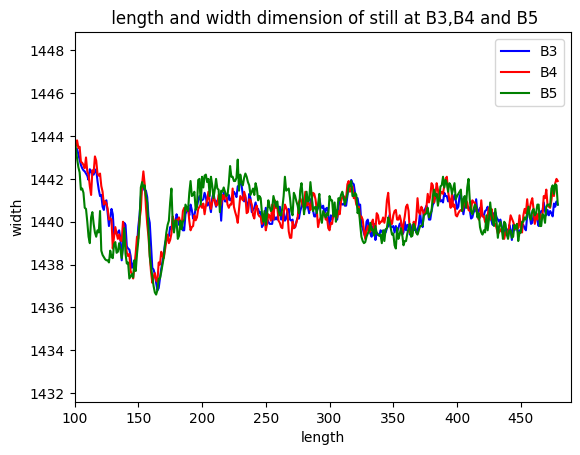

In [13]:
def visualize_measurments():
    measurement_df = label_observation()
    x_upper_limit = measurement_df['length'].max() - 10

    measurement_df=measurement_df[(measurement_df.length >=100) &(measurement_df.length <= x_upper_limit -10)]
    y_lower_limit, y_higher_limit = measurement_df[['width_B3', 'width_B4','width_B5']].min().min().min(), measurement_df[['width_B3', 'width_B4','width_B5']].max().max().max()
    print(measurement_df.head())
    
    plt.plot(measurement_df['length'], measurement_df['width_B3'], color = 'b', label = 'B3')
    plt.plot(measurement_df['length'], measurement_df['width_B4'], color = 'r', label = 'B4')
    plt.plot(measurement_df['length'], measurement_df['width_B5'], color = 'g', label = 'B5')

    plt.xlabel("length")
    plt.ylabel("width")
    plt.title(" length and width dimension of still at B3,B4 and B5")
    
    # need to limit according to data
    plt.ylim(y_lower_limit -5, y_higher_limit + 5)
    plt.xlim(100,x_upper_limit)
    plt.legend()
    plt.show()
    
visualize_measurments()
    

In [ ]:


def coil_merge_samples():

  """
  This function extract acoil Id which have B3,B4,B5 values from a file directory, and save to a set.
  It gets mini dataframe from coil_df based on the extracted coil Id.
  And saves the mini dataframe into CoilData.csv file.

  """

  coil_list_const = set() # initiallize a set which will contain unique coil Id
  coil_df = pd.read_excel('data/CoilDataInput.xlsx')
 

  for file in os.listdir('data\SampleProcessedData'):
    if file.endswith("B3.csv"):#check the files which are end with specific extension
      a = file[:6]# print path name of selected files
      coil_list_const.add(a)
  coil_list_const_int =[int(item) for item in coil_list_const]# cast coil Id to int
  coil_merge_sample_df = coil_df[coil_df.coil.isin(coil_list_const_int)]
  print(coil_merge_sample_df.head())

  coil_merge_sample_df.to_csv('data/CoilData.csv', index=False,header=True) # save df into csv file
  

coil_merge_samples()
  